## Определение перспективного тарифа для телеком компании

Оператор сотовой связи предлагает своим клиентам два разных тарифных плана. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
  
Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за рассматриваемый период. Учтём, что данный оператор сотовой связи всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.  
  
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## План выполнения проекта

### 1. Подготовка данных

- Привести данные к нужным типам;
- Найти и исправить ошибки в данных.
  
  Посчитайте для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

### 2. Анализ данных
Описать поведение клиентов оператора, исходя из выборки. 
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
- Посчитать среднее количество, дисперсию и стандартное отклонение.
- Построить гистограммы. Описать распределения.

### 3. Проверка гипотез

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

### 4. Общий вывод

### Шаг 1. Изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
calls_data = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
internet_data = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'], index_col=0)
messages_data = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv', parse_dates=['reg_date', 'churn_date'])

В ходе загрузки данных таблицы `internet_data` была обнаружена проблема. В датафрейме отображался лишний столбец с индексом. Видимо, при сохранении данных командой `to_csv` не был установлен флаг `index=False`. Чтобы верно считать эти данные, мы указали явно, какой столбец использовать как индекс.

In [3]:
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


В таблице 202607 строк и 4 столбца. Пропусков нет. Все типы данных верные.

In [4]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


В таблице 149396 строк и 4 столбца. Пропусков нет. Типы данных определены верно.

In [5]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


В таблице 123036 строк и 3 столбца. Пропусков нет. Типы данных верные.

In [6]:
tariffs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В таблице 2 строки и 8 столбцов. Типы данных верные. Пропусков нет.

In [7]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


В таблице 500 строк и 8 столбцов. Типы данных определены верно. Пропуски только в столбце `churn_date`. Они означают, что тариф еще действует и пользователь еще не отключился от него.

### Шаг 2. Подготовка данных

Проверим нет ли в данных аномальных значений.

In [8]:
tariffs_data

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


С датасетом описания тарифов всё в порядке.

#### Рассмотрим данные о пользователях

In [9]:
users_data['age'].value_counts().head()

53    14
42    14
63    13
71    13
64    13
Name: age, dtype: int64

Все значения возраста корректны.

In [10]:
users_data['city'].value_counts().sort_index().head()

Архангельск    1
Астрахань      4
Балашиха       5
Барнаул        3
Белгород       2
Name: city, dtype: int64

In [11]:
users_data['city'].nunique()

76

У нас есть записи о 76 городах. Все города записаны корректно, дубликатов нет.

In [12]:
users_data['first_name'].value_counts().sort_index().head()

Авксентий    3
Агата        1
Агафья       2
Агнесса      2
Адам         4
Name: first_name, dtype: int64

In [13]:
users_data['first_name'].nunique()

246

In [14]:
users_data['last_name'].value_counts().sort_index().head()

Ёлчина     1
Ёркин      1
Ёркина     1
Ёрохов     2
Ёрохова    1
Name: last_name, dtype: int64

In [15]:
users_data['last_name'].nunique()

419

В списке имен есть такие как `Габриель`, `Габриэль`, `Рустем`, `Рустэм`. Будем считать их разными именами. 
Всего у нас 246 уникальных имен и 419 уникальных фамилий.

In [16]:
users_data['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Столбец тарифов заполнен верно.

In [17]:
users_data['reg_date'].describe()

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

In [18]:
users_data[users_data['reg_date'] < users_data['churn_date']]['churn_date'].count()

38

Данные собраны за весь 2018 год. 
Дата окончания использования тарифа записана верно. Всего таких значений у нас 38 и все они позже даты начала использования тарифа.

#### Рассмотрим данные о сообщениях 

In [19]:
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [20]:
messages_data['message_date'].describe()

count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

Сообщения не отправляли только 1 января. Большинство сообщений было отправлено 31 декабря.

#### Рассмотрим данные интернет трафика

In [21]:
internet_data.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [22]:
internet_data['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

In [23]:
print('{:.0%}'.format(internet_data.query('mb_used == 0')['mb_used'].shape[0] / internet_data.shape[0]))

13%


Судя по минимальному значению, есть пользователи, которые совсем не используют интернет. Таких в нашей выборке 13%.

In [24]:
internet_data['session_date'].describe()

count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object

Наиболее часто интернет использовали также 31 декабря.  
Данные выглядят корректно.

#### Рассмотрим данные интернет звонков

In [25]:
calls_data.columns

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

In [26]:
calls_data['call_date'].describe()

count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object

In [27]:
calls_data['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Видим минимальную длительность звонков 0 минут. Может быть, это набранные по ошибке номера - люди вовремя замечали ошибку и успевали сбросить до начала разговора. Или люди хотят, чтобы им перезвонили. Возможно, это мошенники. Посмотрим на распределение.

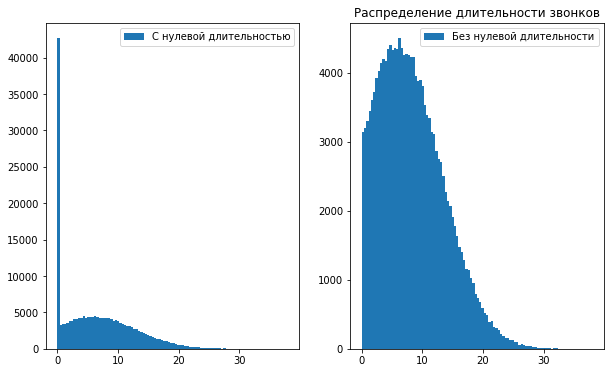

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist('duration', data=calls_data, bins=100, label='С нулевой длительностью')
ax1.legend()
ax2.hist('duration', data=calls_data.query('duration > 0'), bins=100, label='Без нулевой длительности')
ax2.legend()
plt.title('Распределение длительности звонков')
plt.show()

Распределение без звонков нулевой длительности выглядит правдоподобнее. 

In [29]:
print('{:.1%}'.format(calls_data.query('duration == 0')['duration'].count()/calls_data.shape[0]))

19.6%


Да, таких значений много в нашей выборке. Придется от них избавляться.

In [30]:
calls_data.drop(calls_data.query('duration == 0').index, inplace=True)
calls_data.shape[0]

162994

#### Приведем данные к нужным типам

Округлим вверх значения минут разговора и использованного трафика в соответствии с политикой компании и сменим тип данных с `float` на `int`.

In [31]:
calls_data['duration'] = np.ceil(calls_data['duration']).astype(int)
internet_data['mb_used'] = np.ceil(internet_data['mb_used']).astype(int)

### Проведем расчеты

Расчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.

In [32]:
calls_data['month'] = calls_data['call_date'].dt.month

In [33]:
calls_per_month = calls_data.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_per_month.columns = ['calls_count', 'minutes_sum']

Расчитаем количество отправленных сообщений по месяцам.

In [34]:
messages_data['month'] = messages_data['message_date'].dt.month

In [35]:
messages_per_month = messages_data.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_per_month.columns = ['messages_count']

Рассчитаем объем израсходованного интернет-трафика по месяцам.

In [36]:
internet_data['month'] = internet_data['session_date'].dt.month
traffic_per_month = internet_data.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

Соберем посчитанные столбцы в одну таблицу.

In [37]:
all_stat = pd.concat([calls_per_month, messages_per_month, traffic_per_month], axis=1)

In [38]:
all_stat.isna().sum()

calls_count        46
minutes_sum        46
messages_count    497
mb_used            11
dtype: int64

В полученной таблице есть пропуски, так как не все пользователи каждый месяц могли одновременно тратить и смс, и минуты разговора, и мегабайты трафика. Это нормально.

Так как все значения округлены до целых, типы данных столбцов также будут целые.

In [39]:
all_stat = all_stat.apply(lambda x: x.astype('Int64'))

Добавим в нашу результирующую таблицу столбец с тарифом и информацию о том, сколько времени используется тариф.

In [40]:
users_tariff = users_data[['user_id', 'tariff', 'churn_date', 'reg_date', 'city']].copy()
users_tariff['days_in_use'] = users_tariff['churn_date'] - users_tariff['reg_date']
users_tariff['days_in_use'] = (users_tariff['days_in_use']/ np.timedelta64(1, 'D')).astype('Int64')

users_tariff.set_index('user_id', inplace=True)

В ходе исследования были обнаружены пользователи, которые вообще не использовали никакие услуги оператора и отключились через несколько дней подключения. Удалим их.

In [41]:
users_tariff.drop(index=[1128, 1371], axis=0, inplace=True)

Добавим столбец, показывающий, пользуется ли на данный момент клиент услугами компании.

In [42]:
users_tariff['is_churn'] = False
users_tariff.loc[~users_tariff['churn_date'].isna(), 'is_churn'] = True
users_tariff.drop(columns=['churn_date', 'reg_date'], axis=1, inplace=True)

Добавим столбец, показывающий, пользователь из Москвы или из другого города.

In [43]:
users_tariff['is_moscow'] = False
users_tariff.loc[users_tariff['city'] == 'Москва', 'is_moscow'] = True
users_tariff.drop(columns=['city'], axis=1, inplace=True)

In [44]:
all_stat = all_stat.join(users_tariff, on='user_id', how='left')

In [45]:
all_stat.head()

calls_count  minutes_sum  messages_count  mb_used tariff  \
user_id month                                                             
1000    5               17          159              22     2256  ultra   
        6               28          172              60    23257  ultra   
        7               41          340              75    14016  ultra   
        8               42          408              81    14070  ultra   
        9               46          466              57    14581  ultra   

               days_in_use  is_churn  is_moscow  
user_id month                                    
1000    5              NaN     False      False  
        6              NaN     False      False  
        7              NaN     False      False  
        8              NaN     False      False  
        9              NaN     False      False

Вычислим помесячную выручку с каждого пользователя.

In [46]:
def calculate_total(row, tariff_info):  
    """
    Подсчитывает и возвращает общий расход пользователя в месяц на сотовую связь и интернет,
    переплату пользователя сверх тарифной ставки, величину тарифной ставки.
    Принимает параметры:
    row - строка таблицы с израсходованными минутами, смс и мегабайтами,
    tariff_info - датафрейм со стоимостью услуг по тарифам.
    """
    user_id = row.name[0] 
    tariff = row["tariff"]
    tariff_index = tariff_info.query('tariff_name == @tariff').index[0]
    
    # Информация о ценах по данному тарифу
    tariff_data = tariff_info.loc[tariff_index]
    
    gb_count = 0
    total = 0
    overpayment = 0
    
    # Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика.
    # Остаток умножим на значение из тарифного плана.
    minutes_left = row['minutes_sum'] - tariff_data['minutes_included']
    if (minutes_left > 0):
        overpayment += minutes_left * tariff_data['rub_per_minute']  
        
    msg_left = row['messages_count'] - tariff_data['messages_included']  
    if (msg_left > 0):
        overpayment += msg_left * tariff_data['rub_per_message']
                
    mb_left = row['mb_used'] - tariff_data['mb_per_month_included'] 
    if (mb_left > 0):
        gb_count = np.ceil(mb_left / 1024)
        overpayment += gb_count * tariff_data['rub_per_gb']
    
    # Прибавим абонентскую плату, соответствующую тарифному плану
    total = overpayment + tariff_data['rub_monthly_fee']    
    return total, overpayment, tariff_data['rub_monthly_fee']

In [47]:
all_stat['total'], all_stat['overpayment'], all_stat['monthly_fee'] = \
zip(*all_stat.apply(calculate_total, args=(tariffs_data,), axis=1))

In [48]:
all_stat.head()

calls_count  minutes_sum  messages_count  mb_used tariff  \
user_id month                                                             
1000    5               17          159              22     2256  ultra   
        6               28          172              60    23257  ultra   
        7               41          340              75    14016  ultra   
        8               42          408              81    14070  ultra   
        9               46          466              57    14581  ultra   

               days_in_use  is_churn  is_moscow   total  overpayment  \
user_id month                                                          
1000    5              NaN     False      False  1950.0          0.0   
        6              NaN     False      False  1950.0          0.0   
        7              NaN     False      False  1950.0          0.0   
        8              NaN     False      False  1950.0          0.0   
        9              NaN     False      False  1950.0          0.0   

               monthly_fee  
user_id month               
1000    5             1950  
        6             1950  
        7             1950  
        8             1950  
        9             1950

### Шаг 3. Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [49]:
def analyse_features(column):
    """
    Считает дисперсию, стандартное отклонение и среднее для столбца column
    и возвращает объект Series из этих данных
    """
    variance_estimate = np.var(column, ddof=1)
    standard_deviation = np.std(column, ddof=1)
    mean = column.mean()    
    stat_table = pd.Series({'variance_estimate':variance_estimate, 'standard_deviation': standard_deviation, \
                            'mean': mean})
    return stat_table

In [50]:
print('Статистика по тарифу Smart:')

smart_stat = all_stat.query('tariff == "smart"')[['calls_count', 'minutes_sum', 'messages_count', 'mb_used']]\
.apply(analyse_features, axis=0)

tariff_included_row = [0, tariffs_data.loc[0, 'minutes_included'], \
       tariffs_data.loc[0, 'messages_included'], tariffs_data.loc[0, 'mb_per_month_included']]
smart_stat.loc['tariff_included'] = tariff_included_row
smart_stat

Статистика по тарифу Smart:


,calls_count,minutes_sum,messages_count,mb_used
variance_estimate,436.270629,35718.128534,717.594201,3.444310e+07
standard_deviation,20.887092,188.992403,26.787949,5.868824e+03
mean,47.116614,419.440342,38.716441,1.623647e+04
tariff_included,0.000000,500.000000,50.000000,1.536000e+04


In [51]:
print('Статистика по тарифу Ultra:')
ultra_stat = all_stat.query('tariff == "ultra"')[['calls_count', 'minutes_sum', 'messages_count', 'mb_used']]\
.apply(analyse_features, axis=0)

# Добавим строку с информацией о тарифе. Так мы сравним сколько пользователи могли потратить и сколько они потратили
tariff_included_row = [0, tariffs_data.loc[1, 'minutes_included'], \
       tariffs_data.loc[1, 'messages_included'], tariffs_data.loc[1, 'mb_per_month_included']]

ultra_stat.loc['tariff_included'] = tariff_included_row
ultra_stat

Статистика по тарифу Ultra:


,calls_count,minutes_sum,messages_count,mb_used
variance_estimate,1168.901212,93338.428291,2109.659183,9.904344e+07
standard_deviation,34.189197,305.513385,45.931026,9.952057e+03
mean,61.613516,547.755016,61.161006,1.968677e+04
tariff_included,0.000000,3000.000000,1000.000000,3.072000e+04


Можно сказать, что в целом на тарифе Smart пользователи меньше тратят, но и разброс их расходов велик по сравнению с пользователями тарифа Ultra.  
На тарифе Smart люди реже звонят, меньше говорят, меньше пишут смс и меньше используют интернет. Поэтому, видимо, они и выбрали этот тариф. На тарифе Ultra пользователи используют все эти услуги в больших объемах. Также можно заметить большой разброс в использовании интернета и сумме использованных минут разговора.

Построим гистограммы распределений величин.

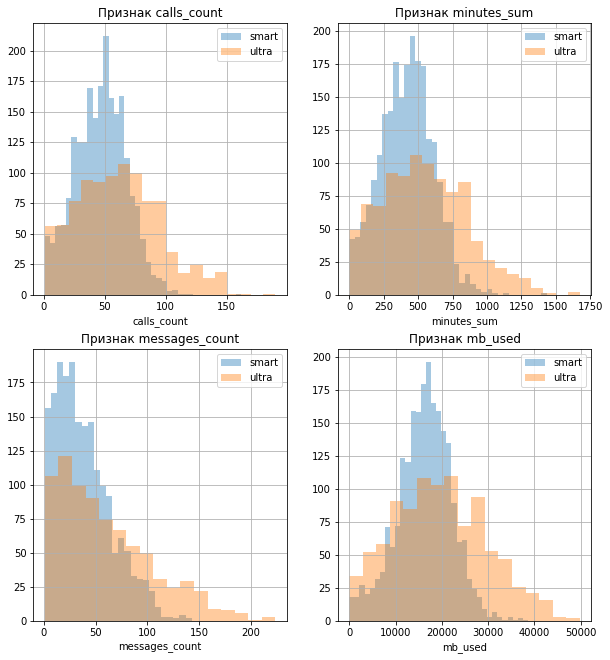

In [52]:
grouped_stat = all_stat.groupby('tariff')
cols_count = 2
rows_count = 2

fig, axes = plt.subplots(rows_count, cols_count, figsize=(10, 11))
cols = ['calls_count', 'minutes_sum', 'messages_count', 'mb_used']

for i in range(0, len(cols)):
    for name, group in grouped_stat:
        row = i // cols_count 
        col = i % cols_count
        sns.distplot(group[cols[i]].dropna(), kde=False, label=name, ax=axes[row, col])
        axes[row, col].grid()       
        axes[row, col].set_xlabel(cols[i])
        axes[row, col].legend()
        axes[row, col].set(title=f'Признак {cols[i]}')
        axes[row, col].grid(True)

Также можно привести график по выручке компании с разбиением по тарифу. 

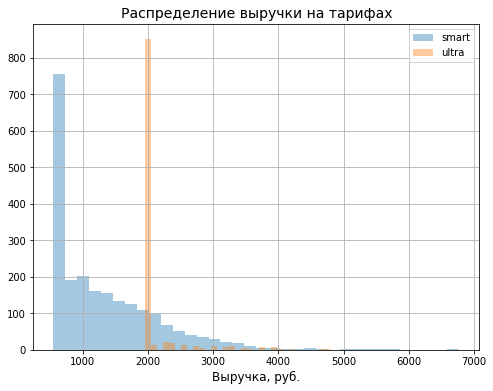

In [53]:
plt.figure(figsize=(8,6))

for name, group in grouped_stat:
    sns.distplot(group['total'].dropna(), kde=False,  label=name)
plt.title('Распределение выручки на тарифах', fontsize=14) 
plt.xlabel('Выручка, руб.', fontsize=12)
plt.legend()
plt.grid()

Посмотрим, какую долю составляют пользователи тарифа ultra.

In [54]:
print('{:.2f}'.format(all_stat.query('tariff == "ultra"').shape[0] / all_stat.shape[0], 0))

0.31


В нашей выборке оказалось всего 31% пользователей тарифа `ultra`.  
Средний пользователь тарифа `smart` звонит от 25 до 70 раз в месяц. Распределение величины нормальное, почти без скосов. Видно, что количество звонков более 100 уже редкое явление на этом тарифе.  
  
В среднем пользователи тарифа `smart` расходуют около 417 минут разговора в месяц. Также в среднем на это требуется около 47 звонков. Распределение нормальное, практически нескошенное. По распределению видно, что пик приходится на время разговоров от 200 до 600 минут в месяц.  

На тарифе `ultra` распределение количества звонков неоднородное. Видно несколько пиков и с 25 - 50 звонками в месяц, и с 50 - 80 звонками. Негладкость распределения вызвана нехваткой данных. Пользователей этого тарифа у нас всего 31%.   
Разговаривают здесь в среднем 526 минут. По распределению видно, что большинство пользователей говорят от 250 до 750 минут. Но пик не ярко выраженный. Распределение чуть скошено вправо. Есть редкие значения разговоров более 1500 минут в месяц.

Пользователи тратят мало сообщений. На тарифе `smart` в среднем пишут до 40 сообщений в месяц. Распределение скошено вправо, так как есть значения и более 120. Но они уже редкость.

На тарифе `ultra` распределение похоже на тариф `smart`. Но здесь значения 70-80 смс в месяц не редкость. В среднем отправляется 61 сообщение ежемесячно. Отметим, что значения больше 200 будем считать редкими.

Распределение величины объема потраченного интернет-трафика на тарифе `smart` нормальное, без скосов, с ярко выраженным пиком между 14000 мб и 20000 мб. Есть и редкие большие значения более 34000 мб. 

Гистограмма интернет-трафика на тарифе `ultra` не такая гладкая. Можно сказать, что пользователи тратят в большинстве своем от 10000 мб до 30000 мб. Будем считать значения более 48000 мб редкими.

### Уберем редкие значения

Построим диаграммы размаха, чтобы убедиться, что мы нашли аномальные значения верно.

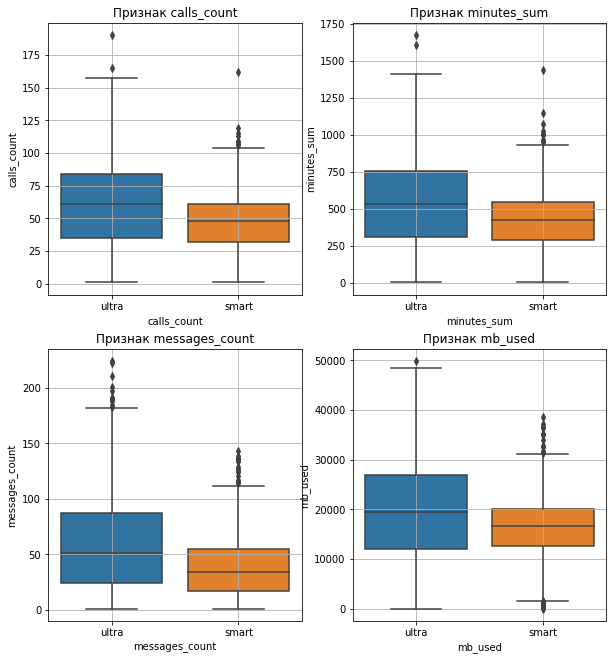

In [55]:
grouped_stat = all_stat.groupby('tariff')
cols_count = 2
rows_count = 2

fig, axes = plt.subplots(rows_count, cols_count, figsize=(10, 11))
cols = ['calls_count', 'minutes_sum', 'messages_count', 'mb_used']

for i in range(0, len(cols)):
    row = i // cols_count 
    col = i % cols_count
    sns.boxplot(y= all_stat[cols[i]].dropna(), x='tariff', data=all_stat, ax=axes[row, col])
    axes[row, col].grid()       
    axes[row, col].set_xlabel(cols[i])
    axes[row, col].set(title=f'Признак {cols[i]}')

Последняя диаграмма подсказывает нам, что на тарифе `smart` есть редкие маленькие значения меньше 1000. Уберем и их.

In [56]:
filtered_stat = all_stat.query('(tariff == "smart" & minutes_sum < 1000 & messages_count < 120 &  1000 < mb_used < 34000) | \
(tariff == "ultra" & minutes_sum < 1500 & messages_count < 200 & mb_used < 48000)').copy()

Построим диаграммы размаха для полученного столбца с выручкой.  

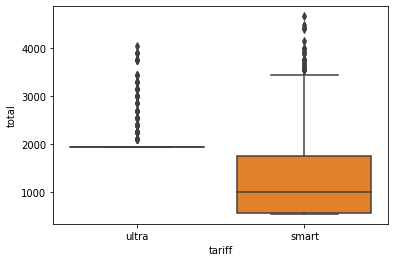

In [57]:
sns.boxplot(y='total', x='tariff', data=filtered_stat);

Такой результат для тарифа `ultra` получился из-за того, что данных мало и почти у всех сумма выручки одна и та же - ставка по тарифу в 1950 рублей. Но мы можем соотнести медианы распределений.

Видим, что больше 75% пользователей тарифа `smart` платят меньше медианы распределения по тарифу `ultra`. Исходя из этих данных можно предположить, что тариф `ultra` более привлекателен для рекламных вложений.

In [58]:
filtered_stat.pivot_table(index='tariff', values='total', aggfunc=['mean', 'sum', 'count'])

,mean,sum,count
,total,total,total
tariff,,,
smart,1271.534079,2387941.0,1878
ultra,2046.572581,1522650.0,744


Исходя из данных таблицы можем сделать предположение, что средние выручки по тарифам отличаются.  
Из таблицы видно, что в пересчете на пользователя средняя выручка по тарифу `ultra` больше. Но так как в нашей выборке таких пользователей меньше, суммарно доход больше от пользователей тарифа `smart`.

In [59]:
def create_overpayment_stat(filtered_stat, tariffs_data):
    """
    Возвращает таблицу с информацией о средних значениях переплат пользователей,
    сгруппированную по тарифам
    """
    overpayment_stat = filtered_stat.groupby('tariff')\
    .agg({'overpayment': ['mean', 'count'], 'total': ['count', 'mean']})
    
    # Найдем какой процент пользователей данного тарифа платит больше тарифной ставки
    overpayment_stat['overpay_percent'] = \
    round(overpayment_stat['overpayment']['count']/overpayment_stat['total']['count'], 2) * 100
    
    # Добавим для наглядности саму тарифную ставку
    overpayment_stat['tariff_fee'] = tariffs_data['rub_monthly_fee'].to_list()
    
    # Удалим вспомогательные столбцы
    overpayment_stat.drop([('total', 'count'), ('overpayment', 'count')], axis=1, inplace=True)
    overpayment_stat.columns = overpayment_stat.columns.droplevel(1)
    
    # Переименуем бывшие столбцы с мультииндексом
    overpayment_stat.rename(columns={'overpayment': "overpayment_mean", 'total': "total_mean"}, inplace=True)
    
    return overpayment_stat

Те строки, в которых переплата равна 0, заполним NaN, чтобы легче было считать count для этого столбца.

In [60]:
filtered_stat.loc[filtered_stat['overpayment'] == 0, 'overpayment'] = np.NaN

In [61]:
overpay_stat = create_overpayment_stat(filtered_stat, tariffs_data)
overpay_stat

,overpayment_mean,total_mean,overpay_percent,tariff_fee
tariff,,,,
smart,954.926709,1271.534079,76.0,550
ultra,807.303371,2046.572581,12.0,1950


Как видим, 76% пользователей тарифа `smart` и всего 12% пользователей тарифа `ultra`превышают тарифные лимиты минут, смс или трафика. В среднем переплата у пользователей тарифа `smart` больше и заметно привышает плату по данному тарифу.

Рассмотрим пользователей из Москвы.

In [62]:
print('{:.2%}'.format(filtered_stat.query('is_moscow == True')['is_moscow'].sum()/filtered_stat.shape[0]))

18.61%


В нашей выборке 18.61% записей о пользователях из Москвы.

Посмотрим на статистики в зависимости от города.

In [63]:
print('Статистика для жителей Москвы:')
filtered_stat.query('is_moscow == True')[['calls_count', 'minutes_sum', 'messages_count', 'mb_used']]\
.apply(analyse_features, axis=0)

Статистика для жителей Москвы:


,calls_count,minutes_sum,messages_count,mb_used
variance_estimate,770.231355,61000.554411,1281.353940,6.346409e+07
standard_deviation,27.753042,246.982903,35.796005,7.966435e+03
mean,53.145492,471.747951,47.266393,1.853124e+04


In [64]:
print('Статистика для жителей других городов:')
filtered_stat.query('is_moscow == False')[['calls_count', 'minutes_sum', 'messages_count', 'mb_used']]\
.apply(analyse_features, axis=0)

Статистика для жителей других городов:


,calls_count,minutes_sum,messages_count,mb_used
variance_estimate,637.951693,51548.930723,1087.675212,4.700032e+07
standard_deviation,25.257706,227.043896,32.979921,6.855678e+03
mean,51.086692,454.758201,44.192127,1.689388e+04


По статистикам видим, что в среднем жители Москвы делают больше звонков в месяц (53 против 51), у них больше средняя длительность разговоров (471 против 454), они отправляют больше смс (47 против 44) и используют больше трафика интернета (18531 мб против 16893 мб). Следует отметить также, что стандартное отклонение всех величин в выборке по городу Москва также выше. Но разница эта не сильно велика. Трудно сказать, достаточно ли этой разницы, чтобы сказать, что поведение и выручка пользователей из Москвы отличаются от пользователей из других городов.

Посмотрим на распределения величин.

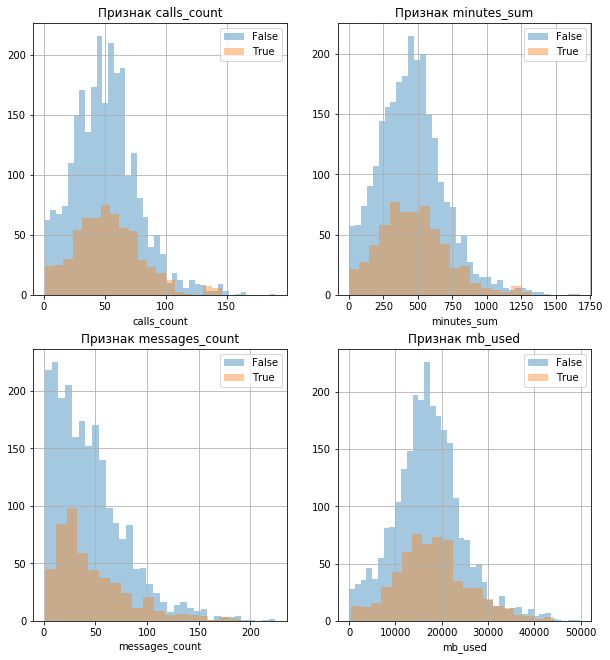

In [65]:
grouped_moscow_stat = all_stat.groupby('is_moscow')
cols_count = 2
rows_count = 2

fig, axes = plt.subplots(rows_count, cols_count, figsize=(10, 11))
cols = ['calls_count', 'minutes_sum', 'messages_count', 'mb_used']

for i in range(0, len(cols)):
    for name, group in grouped_moscow_stat:
        row = i // cols_count 
        col = i % cols_count
        sns.distplot(group[cols[i]].dropna(), kde=False, label=name, ax=axes[row, col])
        axes[row, col].grid(True)       
        axes[row, col].set_xlabel(cols[i])
        axes[row, col].legend()
        axes[row, col].set(title=f'Признак {cols[i]}')

Графики также наглядно показывают - пик количества звонков в выборке по городу Москва чуть сдвинут в сторону больше 50 тогда, как в других городах он в районе 50 звонков в месяц.  
Гистограммы суммы минут разговора в Москве и в других городах схожи, но гистограмма Москвы не такая гладкая.  
На гистограмме количества потраченных смс пик в Москве дальше от 0, чем в других городах.  
Гистограммы интернет трафика похожи между собой.  
Исходя из полученных данных, сложно сказать, отличается средняя выручка пользователей из Москвы от выручки пользователей из других городов или нет.

In [66]:
filtered_stat.pivot_table(index='is_moscow', values='total', aggfunc=['mean', 'sum', 'count'])

,mean,sum,count
,total,total,total
is_moscow,,,
False,1478.685567,3155515.0,2134
True,1547.286885,755076.0,488


Также видим, что средняя выручка для жителя Москвы выше, чем выручка из других городов. Но разница невелика. Пользователей из Москвы в нашей выборке меньше, чем из других городов. Выборка несбалансирована по этому признаку.

Рассмотрим выборку пользователей, отказавшихся от тарифного плана.

In [67]:
filtered_stat.pivot_table(index=['is_churn', 'tariff'], values=['total', 'overpayment'], aggfunc=['mean', 'count'])

mean                    count      
                 overpayment        total overpayment total
is_churn tariff                                            
False    smart    949.896628  1277.898315        1364  1780
         ultra    795.882353  2046.230441          85   703
True     smart   1079.672727  1155.938776          55    98
         ultra   1050.000000  2052.439024           4    41

На тарифе `smart` больше половины пользователей, отказавшихся от услуг оператора, платила больше тарифной ставки. Но стоит заметить, что на том же тарифе пользователи, которые продолжали им пользоваться, гораздо больше, чем в половине случаев также превышали лимиты пакета услуг.

In [68]:
filtered_stat.query('is_churn == True')['days_in_use'].describe()

count    139.000000
mean     157.330935
std       76.197530
min       23.000000
25%       95.000000
50%      142.000000
75%      224.000000
max      284.000000
Name: days_in_use, dtype: float64

В среднем клиенты оператора пользовались услугами меньше полугода. А кто-то и меньше месяца.

In [69]:
print('Статистика по тарифу Smart:')

smart_stat = filtered_stat.query('is_churn == True & overpayment.isna() & tariff == "smart"')\
[['calls_count', 'minutes_sum', 'messages_count', 'mb_used']]\
.apply(analyse_features, axis=0)

tariff_included_row = [0, tariffs_data.loc[0, 'minutes_included'], \
       tariffs_data.loc[0, 'messages_included'], tariffs_data.loc[0, 'mb_per_month_included']]
smart_stat.loc['tariff_included'] = tariff_included_row
smart_stat

Статистика по тарифу Smart:


,calls_count,minutes_sum,messages_count,mb_used
variance_estimate,184.375415,15367.825028,144.664452,1.636956e+07
standard_deviation,13.578491,123.967032,12.027654,4.045931e+03
mean,29.651163,265.279070,21.046512,9.489279e+03
tariff_included,0.000000,500.000000,50.000000,1.536000e+04


In [70]:
print('Статистика по тарифу Ultra:')

ultra_stat = filtered_stat.query('is_churn == True & overpayment.isna() & tariff == "ultra"')\
[['calls_count', 'minutes_sum', 'messages_count', 'mb_used']].apply(analyse_features, axis=0)

tariff_included_row = [0, tariffs_data.loc[0, 'minutes_included'], \
       tariffs_data.loc[0, 'messages_included'], tariffs_data.loc[0, 'mb_per_month_included']]
ultra_stat.loc['tariff_included'] = tariff_included_row
ultra_stat

Статистика по тарифу Ultra:


,calls_count,minutes_sum,messages_count,mb_used
variance_estimate,715.807808,48510.695195,935.768769,7.410234e+07
standard_deviation,26.754585,220.251436,30.590338,8.608272e+03
mean,46.567568,411.837838,47.189189,1.517611e+04
tariff_included,0.000000,500.000000,50.000000,1.536000e+04


Также можем отметить, что среди тех, кто не переплачивал, пользователи тарифа `smart` тратили сильно меньше предлагаемых услуг по пакету тарифа. Может быть они ушли на поиски более дешевого тарифа с меньшими значениями в пакете услуг.  
Пользователи тарифа `ultra` в среднем тратили почти все, что предоставлялось тарифным планом. Они могли нуждаться в тарифе с большими объемами услуг.  

### Шаг 4. Проверка гипотез  
  
- средняя выручка пользователей тарифов `ultra` и `smart` различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Зададим критический уровень статистической значимости.

In [71]:
alpha = 0.05

Наша нулевая гипотеза будет звучать так: средние выручки по тарифам `ultra` и `smart` одинаковы.  
Тогда альтернативная гипотеза будет такой: средние выручки по тарифам `ultra` и `smart` отличаются.

In [72]:
results = st.ttest_ind(filtered_stat.query('tariff == "smart"')['total'], 
                       filtered_stat.query('tariff == "ultra"')['total'])

In [73]:
results.pvalue

5.507813992019588e-138

In [74]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Так как наше значение pvalue гораздо меньше заданного порога статистической значимости, мы отвергаем нулевую гипотезу о том, что средние значения датасетов одинаковы. Таким образом, можем сказать, что средние значения датасетов по разным тарифам действительно отличаются.

Рассмотрим выручки от выборок с пользователями из Москвы и из остальных городов.

Наша нулевая гипотеза будет звучать так: средние выручки пользователей из Москвы и из других регионов одинаковы.  
Альтернативная гипотеза: средние выручки пользователей из Москвы и из других регионов отличны.

In [75]:
moscow_total = filtered_stat.query('is_moscow == True')['total']
other_total = filtered_stat.query('is_moscow == False')['total']

In [76]:
results = st.ttest_ind(moscow_total, other_total)

In [77]:
results.pvalue

0.07143123030728966

In [78]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


Значение pvalue больше заданного порога статистической значимости, мы не можем отвергнуть гипотезу о том, что средние значения датасетов одинаковы. Значит, мы не можем сказать, что выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Общий вывод

Целью нашего исследования было проанализировать поведение клиентов на двух разных тарифах сотовой связи и сделать вывод — какой тариф лучше.  
В нашей выборке оказалось всего 31% пользователей тарифа `ultra`.    
Мы выяснили, что пользователи тарифа `smart` в среднем говорят реже, меньше (417 минут разговора smart/526 минут разговора ultra), тратят меньше смс (38 смс smart/61 смс ultra) и интернет трафика (16236 мб smart / 30720 мб ultra), чем пользователи тарифа `ultra`.

Видим, что больше 75% пользователей тарифа `smart` платят меньше медианы распределения по тарифу `ultra`.  

По данным о выручке выяснили, что в пересчете на пользователя средняя выручка по тарифу `ultra` больше. Но так как в нашей выборке таких пользователей меньше, суммарно доход больше от пользователей тарифа `smart`.  
Исходя из полученных статистик мы выдвинули гипотезу, что средние выручки по тарифам отличаются. В дальнейшем мы смогли её подтвердить.   

Предположение о том, что поведение и выручка пользователей из города Москва может как-то отличаться от пользователей в других городах не подтвердилось.

Стоит также заметить, что пользователи тарифа `smart` часто платят больше тарифной ставки, так как тратят больше минут разговора, интернет трафика, чем предлагает тариф. Но итоговая сумма их оплаты все равно меньше, чем пакет тарифа `ultra`. Этим пользователям можно предложить перейти на тариф `ultra`, где запас минут, смс и трафика значительно больше. Также напомню, что в пересчете на пользователя, прибыль с тарифа `ultra` больше.  
В заключение, можем сделать вывод, что тариф `ultra` более перспективен для привлечения клиентов.